![](https://i.imgur.com/eBRPvWB.png)

# 使用seq2seq网络和注意力机制实现汉-英翻译

这个项目，我们会实现一个汉语到英语的神经网络翻译模型。


这里实现的是论文[seq2seq 网络](http://arxiv.org/abs/1409.3215)的系统，它通过两个RNN来实现把一个训练翻译成两位一个序列。Encoder把输入序列编码成一个向量，而Decoder会把这个向量解码成两位一个输出序列。

为了提升效果，我们使用了[注意力机制](https://arxiv.org/abs/1409.0473)，它可以让decoder学习到在翻译的过程中怎么重点关注输入序列的某一部分。

## sequence to sequence模型

sequence to sequence模型，或者说seq2seq模型，由两个RNN组成。这两个RNN分别叫做encoder和decoder。
encoder会一个词一个出的读入输入序列，每一步都有一个输出，而最后的输出叫做context向量，我们可以认为是模型对源语言句子“语义”的一种表示。而decoder用这个context向量一步一步的生成目标语言的句子。

![](seq2seq.png)

为什么要两个RNN呢，如果我们使用一个RNN，输入和输出是一对一的关系（对于分类，我们可以只使用最后一个输出），但是翻译肯定不是一个词对一个词的翻译。当然这只是使用两个RNN在形式上的方便，从“原理”上来说，人类翻译也是类似的，首先仔细阅读源语句，然后“理解”它，而所谓的“理解”在seq2seq模型里可以认为encoding的过程，然后再根据理解，翻译成目标语句。

## 注意力机制

用一个固定长度的向量来承载输入序列的完整“语义”，不管向量能有多长，都是很困难的事情。

[Bahdanau et al.等人引入的](https://arxiv.org/abs/1409.0473) **注意力机制**试图这样来解决这个问题：我们不依赖于一个固定长度的向量，而是通过“注意”输入的某些部分。在decoer每一步解码的时候都通过这个机制来选择输入的一部分来重点考虑。这似乎是合乎人类的翻译过程的——我们首先通过一个encoder大致理解句子的意思（编码到一个定长向量），具体翻译某个词或者短语的时候我们会仔细推敲对应的源语言的词（注意力机制）。

![](5y6SCvU.png)

注意力是通过decoder的另外一个神经网络层来计算的。它的输入是当前输入和上一个时刻的隐状态，输出是一个新的向量，这个向量的长度和输入相同（因为输入是变长的，我们会选择一个最大的长度），这个向量会用softmax变成“概率”，得到*注意力权重*，这个权重可以认为需要花费多大的“注意力”到某个输入上，因此我们会用这个权重加权平均encoder的输出，从而得到一个新的context向量，这个向量会用来预测当前时刻的输出。

![](K1qMPxs.png)

## 依赖

我们需要[PyTorch](http://pytorch.org/)来构建和训练模型，需要[matplotlib](https://matplotlib.org/) 来绘图，剩下的都是Python自带的库。

In [1]:
import unicodedata
import string
import re
import random
import time
import datetime
import math
import socket
hostname = socket.gethostname()

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence#, masked_cross_entropy
from masked_cross_entropy import *

import matplotlib.pyplot as plt
plt.rcParams[u'font.sans-serif'] = ['simhei']
plt.rcParams['axes.unicode_minus'] = False
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

如果没有GPU，请设置为False，但是训练时间可能会比较长。

In [2]:
USE_CUDA = True

## 加载数据

训练数据是几千个英语到汉语的平行句对。我们这里只是介绍算法，所以使用一个很小的数据集来演示。数据在data/eng-chn.txt里，格式如下：
```
I won!  我 赢 了 。
```

每一行都是一个句对，用tab分割，中文部分已经提前分完词了(空格分开，所以split就可以得到中文的词)。

我们会用one-hot的方法来表示一个单词。

### 单词变成数字

我们会创建一个Lang对象来表示源/目标语言，它包含word2idx、idx2word和word2count，分别表示单词到id、id到单词和单词的词频。
word2count的作用是用于过滤一些低频词（把它变成unknown）

In [3]:
#按字分词，目前不需要了。
def seg_cn_words(s):
    words=[]
    for ch in s:
        if ch !=' ':
            words.append(ch)
    return words

In [4]:
PAD_token = 0
SOS_token = 1
EOS_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.n_words = 3 # Count default tokens

    def seg_words(self, sentence):
#        if self.name=='chn':
#            return seg_cn_words(sentence)
        return sentence.split(' ')
        
    def index_words(self, sentence):
        words=self.seg_words(sentence)
        for word in words:
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    # 删除掉频率少于阈值的此。
    def trim(self, min_count):
        if self.trimmed: return
        self.trimmed = True
        
        keep_words = []
        
        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words %s / %s = %.4f' % (
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # 重新构建dict
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.n_words = 3 # 默认3个词。

        for word in keep_words:
            self.index_word(word)

### 读取和预处理 

我们会只保留文本里的英文和中文字符，把大小转换成小写。

In [5]:

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 大写转小写，trim，移除常见标点，英文和中文之外的字符。
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([,.!?])", r" \1 ", s)
    s = re.sub(r"[^a-zA-Z\u4e00-\u9fa5,.!?，。！？]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

In [6]:
s=unicode_to_ascii("中文word  cn!")
print(s)
s=normalize_string(s)
print(s)

中文word  cn!
中文word cn !


文件格式是每行一个句对，用tab分隔，第一个是英语，第二个是汉语，为了方便未来的复用，我们有一个reverse参数，这样如果我们需要汉语到英语的翻译就可以用到。如果读者想实现英语到汉英的翻译系统，那么只需要reverse为False就行。

In [7]:
def read_langs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # 读取文件
    filename = '../data/%s-%s.txt' % (lang1, lang2)
    lines = open(filename).read().strip().split('\n')

    # Split
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]

    # 反转句对，从英汉变成汉英
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [8]:
MIN_LENGTH = 3
MAX_LENGTH = 25

def filter_pairs(pairs):
    filtered_pairs = []
    for pair in pairs:
        if len(pair[0]) >= MIN_LENGTH and len(pair[0]) <= MAX_LENGTH \
            and len(pair[1]) >= MIN_LENGTH and len(pair[1]) <= MAX_LENGTH:
                filtered_pairs.append(pair)
    return filtered_pairs

数据处理过程如下：

* 读取文件，split成行，再split成pair
* 文本归一化，过滤掉过短(小于3)和过长(大于25)的句对。
* 通过pair里的句子得到单词列表


In [9]:
def prepare_data(lang1_name, lang2_name, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1_name, lang2_name, reverse)
    print("Read %d sentence pairs" % len(pairs))
    
    pairs = filter_pairs(pairs)
    print("Filtered to %d pairs" % len(pairs))
    
    print("Indexing words...")
    for pair in pairs:
        input_lang.index_words(pair[0])
        output_lang.index_words(pair[1])
    
    print('Indexed %d words in input language, %d words in output' % (input_lang.n_words, output_lang.n_words))
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepare_data('eng', 'chn', True)

Reading lines...
Read 19777 sentence pairs
Filtered to 5095 pairs
Indexing words...
Indexed 2930 words in input language, 2258 words in output


### 过滤词汇 

我们会取得词频低于5的词语。对于低频的词和词典之外的词(OOV)，系统很难学习，这是学术研究的一个难点，我们暂时忽略掉这些低频词。

In [10]:
MIN_COUNT = 5

input_lang.trim(MIN_COUNT)
output_lang.trim(MIN_COUNT)

keep_words 578 / 2927 = 0.1975
keep_words 568 / 2255 = 0.2519


In [11]:
print(input_lang.name)

chn


### 过滤句对

我们接下来去掉包含低频词或者OOV的句对。

In [12]:
keep_pairs = []

for pair in pairs:
    input_sentence = pair[0]
    output_sentence = pair[1]
    keep_input = True
    keep_output = True
    words=input_lang.seg_words(input_sentence)
    for word in words:
        if word not in input_lang.word2index:
            keep_input = False
            break
            
    words=output_lang.seg_words(output_sentence)
    for word in words:
        if word not in output_lang.word2index:
            keep_output = False
            break

    # Remove if pair doesn't match input and output conditions
    if keep_input and keep_output:
        keep_pairs.append(pair)

print("Trimmed from %d pairs to %d, %.4f of total" % (len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
pairs = keep_pairs


Trimmed from 5095 pairs to 1854, 0.3639 of total


In [13]:
print(pairs[2])

['我 赢 了 。', 'i won !']


## 把训练数据变成Tensor/Variable

为了让神经网络能够处理，我们首先需要把句子变成Tensor。每个句子首先分成词，每个词被替换成对应的index。另外我们会增加一个特殊的EOS来表示句子的结束。

![](https://i.imgur.com/LzocpGH.png)

在PyTorch里一个Tensor是一个多维数组，它的所有元素的数据类型都是一样的。我们这里使用LongTensor来表示词的index。

可以训练的PyTorch模块要求输入是Variable而不是Tensor。变量除了包含Tensor的内容之外，它还会跟踪计算图的状态，从而可以进行自动梯度的求值。

In [14]:
# 把句子变成index的list，最后加上EOS
def indexes_from_sentence(lang, sentence):
    idxs=[]
    words=lang.seg_words(sentence)
    for word in words:
        if word in lang.word2index:
            idxs.append(lang.word2index[word])
    idxs.append(EOS_token)
    return idxs

为了更好的使用GPU，我们一次训练一个batch的数据，但是问题是不同句对的长度是不一样的。解决办法是通过“pad”来把短的序列补到和长的序列一样长，我们需要一个特殊的整数来表示它是一个pad值而不是其他的词，我们这里使用0。当计算loss的时候，我们也需要把这些0对应的loss去掉（因为实际的序列到这里已经没有了，但是padding之后任何会计算出模型的预测值，从而有loss）


![](https://i.imgur.com/gGlkEEF.png)

In [15]:
# 把一个序列padding到长度为max_length。
def pad_seq(seq, max_length):
    seq += [PAD_token for i in range(max_length - len(seq))]
    return seq

训练一次需要一个batch的数据，我们一般随机的抽取bach_size个句对，然后把它们padding到最长的序列长度。此外，我们需要记录下未padding之前的长度，因为计算loss的时候会需要用到它。

我们会用list的list来初始化LongTensor，这个list的大小是batch_size，list的每个元素是一个序列(句子)。这样我们可以得到一个`(batch_size x max_len)`的Tensor，但是因为训练时我们需要逐个时刻的计算batch_size个数据，所以我们需要把它转置成`(max_len x batch_size)`。这样tensor[t]就表示t时刻的batch_size个词。


![](https://i.imgur.com/nBxTG3v.png)

In [16]:
def random_batch(batch_size):
    input_seqs = []
    target_seqs = []

    # 随机选择pairs
    for i in range(batch_size):
        pair = random.choice(pairs)
        input_seqs.append(indexes_from_sentence(input_lang, pair[0]))
        target_seqs.append(indexes_from_sentence(output_lang, pair[1]))

    # 把输入和输出序列zip起来，通过输入的长度降序排列，然后unzip
    seq_pairs = sorted(zip(input_seqs, target_seqs), key=lambda p: len(p[0]), reverse=True)
    input_seqs, target_seqs = zip(*seq_pairs)
    
    # 对输入和输出序列都进行padding。
    input_lengths = [len(s) for s in input_seqs]
    input_padded = [pad_seq(s, max(input_lengths)) for s in input_seqs]
    target_lengths = [len(s) for s in target_seqs]
    target_padded = [pad_seq(s, max(target_lengths)) for s in target_seqs]

    # padding之后的shape是(batch_size x max_len)，我们需要把它转置成(max_len x batch_size)
    input_var = Variable(torch.LongTensor(input_padded)).transpose(0, 1)
    target_var = Variable(torch.LongTensor(target_padded)).transpose(0, 1)
    
    if USE_CUDA:
        input_var = input_var.cuda()
        target_var = target_var.cuda()
        
    return input_var, input_lengths, target_var, target_lengths

我们可以测试一下，它会返回两个`(max_len x batch_size)` tensor，这是输入和输出序列，同时也会返回padding之前的实际长度。


In [17]:
random_batch(2)

(tensor([[ 19, 156],
         [ 11,  30],
         [173, 480],
         [ 55, 481],
         [ 72,   3],
         [133,   2],
         [ 26,   0],
         [  2,   0]], device='cuda:0'), [8, 6], tensor([[ 18,  99],
         [274, 140],
         [ 25, 101],
         [144, 476],
         [ 17,   3],
         [ 21,   2],
         [  2,   0]], device='cuda:0'), [7, 6])

# 构建模型

## Encoder

<img src="images/encoder-network.png" style="float: right" />


encoder的输入是batch大小的词序列——大小是`(max_len x batch_size)``LongTensor`，每个词都会输出一个向量，所以最终的输出是大小为  `(max_len x batch_size x hidden_size)`的`FloatTensor`。

输入序列的词会被fed到一个[embedding层 `nn.Embedding`](http://pytorch.org/docs/nn.html#embedding)从而得到每个词的embedding，这样得到一个`(max_len x batch_size x embedding_size【这里embedding_size==hidden_size，但这不是必须相等的】)`的Tensor，这个Tensor会输入到[GRU层 `nn.GRU`](http://pytorch.org/docs/nn.html#gru)。最终GRU的输出是`seq_len x batch_size x hidden_size`。

In [18]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout=0.1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=self.dropout, bidirectional=True)
        
    def forward(self, input_seqs, input_lengths, hidden=None):
        # 注意：和前面的实现不同，这里没有时刻t的for循环，而是一次输入GRU直接计算出来
        embedded = self.embedding(input_seqs)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack
        hidden = self._cat_directions(hidden)
        return outputs, hidden
    
    def _cat_directions(self, hidden):
        """ If the encoder is bidirectional, do the following transformation.
            Ref: https://github.com/IBM/pytorch-seq2seq/blob/master/seq2seq/models/DecoderRNN.py#L176
            -----------------------------------------------------------
            In: (num_layers * num_directions, batch_size, hidden_size)
            (ex: num_layers=2, num_directions=2)

            layer 1: forward__hidden(1)
            layer 1: backward_hidden(1)
            layer 2: forward__hidden(2)
            layer 2: backward_hidden(2)

            -----------------------------------------------------------
            Out: (num_layers, batch_size, hidden_size * num_directions)

            layer 1: forward__hidden(1) backward_hidden(1)
            layer 2: forward__hidden(2) backward_hidden(2)
        """
        def _cat(h):
            return torch.cat([h[0:h.size(0):2], h[1:h.size(0):2]], 2)
            
        if isinstance(hidden, tuple):
            # LSTM hidden contains a tuple (hidden state, cell state)
            hidden = tuple([_cat(h) for h in hidden])
        else:
            # GRU hidden
            hidden = _cat(hidden)
            
        return hidden    

## Attention Decoder

### 理解Bahdanau等人提出的模型

下面我们来学习一下这篇文章提出的 [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473) Attention Decoder。

decoder在每一个时刻的输出依赖与前一个时刻的输出和一个$\mathbf x$，这个$\mathbf x$包括当前的隐状态（它也会考虑前一个时刻的输出）和一个注意力”context“，下文会介绍它。函数$g$是一个带非线性激活的全连接层，它的输入是$y_{i-1}$, $s_i$ 和 $c_i$拼接起来的。

$$
p(y_i \mid \{y_1,...,y_{i-1}\},\mathbf{x}) = g(y_{i-1}, s_i, c_i)
$$

上式的意思是：我们在翻译当前词时只考虑上一个翻译出来的词以及当前的隐状态和注意力context。

当前隐状态$s_i$是有RNN $f$计算出来的，这个RNN的输入是上一个隐状态$s_{i-1}$，decoder的上一个输出$y_{i-1}$和 context向量$c_i$。

在代码实现中，我们使用的RNN是`nn.GRU`，隐状态 $s_i$是`hidden`，输出$y_i$是`output`， context $c_i$ 是`context`。

$$
s_i = f(s_{i-1}, y_{i-1}, c_i)
$$

context向量$c_i$是encoder在每个时刻(词)的输出的加权和，而权值$a_{ij}$表示i时刻需要关注$h_j$的程度(概率)。

$$
c_i = \sum_{j=1}^{T_x} a_{ij} h_j
$$

而权值$a_{ij}$是"能量" $e_{ij}$的softmax。

$$
a_{ij} = \dfrac{exp(e_{ij})}{\sum_{k=1}^{T} exp(e_{ik})}
$$

而能量$e_{ij}$是上个时刻的隐状态$s_{i-1}$和encoder第j个时刻的输出$h_j$的函数：

$$
e_{ij} = a(s_{i-1}, h_j)
$$

### Luong等人提出的模型

Luong等人在[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025)提出了更多的提高和简化。他们描述了”全局注意力“模型，其计算注意力得分的方法和之前不同。前面是通过$s_{i-1}$和$h_j$计算$a_{ij}$，也就是当前的注意力权重依赖与前一个状态，而这里的注意力依赖与decoder当前的隐状态和encoder所有隐状态：

$$
a_t(s) = align(h_t, \bar h_s)  = \dfrac{exp(score(h_t, \bar h_s))}{\sum_{s'} exp(score(h_t, \bar h_{s'}))}
$$

特点的"score"函数会比较两个隐状态的”相似度“，可以是两个向量的内积，也可以是$h_{s'}$做一个线性变换之后和$h_t$的内积，也可以是把两个向量拼接起来然后做一个线性变换，然后和一个参数$v_a$（这个参数是学习出来的）的内积：

$$
score(h_t, \bar h_s) =
\begin{cases}
h_t ^\top \bar h_s & dot \\
h_t ^\top \textbf{W}_a \bar h_s & general \\
v_a ^\top \textbf{W}_a [ h_t ; \bar h_s ] & concat
\end{cases}
$$

scoring函数的模块化定义使得我们可以随意的修改而不影响其它地方的代码。这个模块的输入总是decoder的隐状态和encoder的所有输出。

### 计算注意力的通用模块

为了代码重用，这里把注意力的计算封装成一个模块，不管是哪个算法都可以复用它。

In [19]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size*2, hidden_size*2)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)

        # 创建变量来存储注意力能量
        attn_energies = Variable(torch.zeros(this_batch_size, max_len)) # B x S

        if USE_CUDA:
            attn_energies = attn_energies.cuda()

        # 计算
        for b in range(this_batch_size):
            for i in range(max_len):
                attn_energies[b, i] = self.score(hidden[:, b], encoder_outputs[i, b].unsqueeze(0))

        # softmax并且resize成1 x B x S
        return F.softmax(attn_energies, dim=1).unsqueeze(1)
    
        
    def score(self, hidden, encoder_output):

        if self.method == 'dot':
            energy = hidden.view(-1).dot(encoder_output.view(-1))
            return energy

        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = hidden.view(-1).dot(energy.view(-1))
            return energy

        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = self.other.view(-1).dot(energy.view(-1))
            return energy        

现在我们可以构建一个decoder，它会把Attn模块放到RNN之后用来计算注意力的权重，并且用它来计算context向量。

In [20]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # 保存变量
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # 定义网络层
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size*2, n_layers, dropout=dropout)
        self.concat = nn.Linear(hidden_size * 4, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
        # 选择注意力计算方法
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_seq, last_hidden, encoder_outputs):
        # 注意：我们encoder一次计算所有时刻的数据，但是decoder我们目前还是一次计算一个时刻的（但是是一个batch）
        # 因为Teacher Forcing可以一次计算但是Random Sample必须逐个计算
        # 得到当前输入的embedding 
        batch_size = input_seq.size(0)
        embedded = self.embedding(input_seq)
        embedded = self.embedding_dropout(embedded)
        embedded = embedded.view(1, batch_size, self.hidden_size) # S=1 x B x N

        # 计算gru的输出和新的隐状态，输入是当前词的embedding和之前的隐状态。
        rnn_output, hidden = self.gru(embedded, last_hidden)
        
        
        # 根据当前的RNN状态和encoder的输出计算注意力。
        # 根据注意力计算context向量 
        attn_weights = self.attn(rnn_output, encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x S=1 x N

        # 把gru的输出和context vector拼接起来
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))

        # 预测下一个token，这里没有softmax，只有计算loss的时候才需要。
        output = self.out(concat_output)

        # 返回最终的输出，GRU的隐状态和attetion（用于可视化）
        return output, hidden, attn_weights

## 测试模型

为了初步验证上面的代码是否正确，我们用少量的数据来跑一下。

In [21]:
small_batch_size = 3
input_batches, input_lengths, target_batches, target_lengths = random_batch(small_batch_size)

print('input_batches', input_batches.size()) # (max_len x batch_size)
print('target_batches', target_batches.size()) # (max_len x batch_size)

input_batches torch.Size([5, 3])
target_batches torch.Size([6, 3])


创建一个较小的模型用来验证代码

In [22]:
small_hidden_size = 8
small_n_layers = 2

encoder_test = EncoderRNN(input_lang.n_words, small_hidden_size, small_n_layers)
decoder_test = LuongAttnDecoderRNN('general', small_hidden_size, output_lang.n_words, small_n_layers)

if USE_CUDA:
    encoder_test.cuda()
    decoder_test.cuda()

测试encoder

In [23]:
encoder_outputs, encoder_hidden = encoder_test(input_batches, input_lengths, None)

print('encoder_outputs', encoder_outputs.size()) # max_len x batch_size x hidden_size
print('encoder_hidden', encoder_hidden.size()) # n_layers * 2 x batch_size x hidden_size

encoder_outputs torch.Size([5, 3, 16])
encoder_hidden torch.Size([2, 3, 16])


然后我们从SOS开始，然后用decoder来逐个解码。和encoder不同，encoder是一次处理整个序列，但是decoder必须逐个解码，因为在预测（或者random sampling时）都必须把上一个时刻的输出作为当前时刻的输入。所以前一个时刻没有处理完是没有办法处理下一个时刻的数据的。不过我们仍然是一次处理一个batch的数据的，比如之前的效率还是会提高。


In [24]:
max_target_length = max(target_lengths)

# decoder的第一个输入是SOS
decoder_input = Variable(torch.LongTensor([SOS_token] * small_batch_size))
decoder_hidden = encoder_hidden # 把第一层的encoder的输出作为decoder的输入。
all_decoder_outputs = Variable(torch.zeros(max_target_length, small_batch_size, decoder_test.output_size))

if USE_CUDA:
    all_decoder_outputs = all_decoder_outputs.cuda()
    decoder_input = decoder_input.cuda()

# 遍历Run through decoder one time step at a time
for t in range(max_target_length):
    decoder_output, decoder_hidden, decoder_attn = decoder_test(
        decoder_input, decoder_hidden, encoder_outputs
    )
    all_decoder_outputs[t] = decoder_output # Store this step's outputs
    decoder_input = target_batches[t] # Next input is current target

# 通过mask计算交叉熵
loss = masked_cross_entropy(
    all_decoder_outputs.transpose(0, 1).contiguous(),
    target_batches.transpose(0, 1).contiguous(),
    target_lengths,
    USE_CUDA
)
print('loss', loss.item())

loss 6.273172378540039



## 训练

### 一次训练

对于一个训练数据，我们首先用encoder对输入句子进行编码，得到每个时刻的输出和最后一个时刻的隐状态。最后一个隐状态会作为decoder隐状态的初始值，并且我们会用一个特殊的`<SOS>`作为decoder的第一个输入。


In [25]:
def train(input_batches, input_lengths, target_batches, target_lengths, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    
    # 梯度清空
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # 进行encoding
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)
    
    # 准备输入和输出变量
    decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size))
    decoder_hidden = encoder_hidden
    #decoder_hidden = decoder_hidden.contiguous()
    
    max_target_length = max(target_lengths)
    all_decoder_outputs = Variable(torch.zeros(max_target_length, batch_size, decoder.output_size))


    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        all_decoder_outputs = all_decoder_outputs.cuda()

    # 解码
    for t in range(max_target_length):
        decoder_output, decoder_hidden, decoder_attn = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )

        all_decoder_outputs[t] = decoder_output
        decoder_input = target_batches[t] # 当前输出是下一个时刻的输入。

    # 计算loss和反向计算梯度
    loss = masked_cross_entropy(
        all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
        target_batches.transpose(0, 1).contiguous(), # -> batch x seq
        target_lengths,
        USE_CUDA
    )
    loss.backward()
    
    # clip梯度
    ec = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    dc = torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # 更新参数
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item(), ec, dc

## 进行训练

所有的准备工作都就绪，我们可以开始初始化网络和开始训练。

我们首先初始化模型，优化器，损失函数，以及一些用于绘图和记录进度的变量：

In [26]:
# 模型的配置
attn_model = 'dot'
hidden_size = 500
n_layers = 2
dropout = 0.1
batch_size = 100

# 训练的超参数
clip = 50.0
teacher_forcing_ratio = 0.5
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_epochs = 5000
epoch = 0
plot_every = 20
print_every = 100
evaluate_every = 500

# 初始化模型
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers, dropout=dropout)
decoder = LuongAttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers, dropout=dropout)

# 初始化optimizers和criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
criterion = nn.CrossEntropyLoss()

# 把模型放到GPU上
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

# 计时
start = time.time()
plot_losses = []
print_loss_total = 0 # 每过print_every次清零
plot_loss_total = 0 # 每过plot_every次清零

一些工具函数

In [27]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

## 预测(翻译)


In [28]:
def evaluate(input_seq, max_length=MAX_LENGTH):
    input_seqs = [indexes_from_sentence(input_lang, input_seq)]
    input_lengths=[len(sen) for sen in input_seqs]
    with torch.no_grad():
        input_batches = Variable(torch.LongTensor(input_seqs)).transpose(0, 1)
    
    if USE_CUDA:
        input_batches = input_batches.cuda()
        
    # 预测的时候不需要更新参数
    encoder.train(False)
    decoder.train(False)
    
    # encoding
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)

    # 创建开始的SOS
    with torch.no_grad():
        decoder_input = Variable(torch.LongTensor([SOS_token])) # SOS
    decoder_hidden = encoder_hidden
    #decoder_hidden = decoder_hidden.contiguous()
    
    if USE_CUDA:
        decoder_input = decoder_input.cuda()

    # Store output words and attention states
    decoded_words = []
    decoder_attentions = torch.zeros(max_length + 1, max_length + 1)
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )
        decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi.item()
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([ni]))
        if USE_CUDA: decoder_input = decoder_input.cuda()

    # Set back to training mode
    encoder.train(True)
    decoder.train(True)
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]


我们可以随机选些训练集中的句子来看模型的预测和参考翻译的差异：

In [29]:
def evaluate_randomly():
    [input_sentence, target_sentence] = random.choice(pairs)
    evaluate_and_show_attention(input_sentence, target_sentence)

# 注意力的可视化

注意力机制的一个优点是它的输出的可解释性。因为它在decode每一步都会对所以输入赋予不同的权重，因此我们可以认为它在翻译这个词的时候”对应“了源语言的词的权重，这可以认为是一种对齐。

In [30]:
import io
import torchvision
from PIL import Image
import visdom
vis = visdom.Visdom()

def show_plot_visdom():
    buf = io.BytesIO()
    plt.savefig(buf)
    buf.seek(0)
    attn_win = 'attention (%s)' % hostname
    vis.image(torchvision.transforms.ToTensor()(Image.open(buf)), win=attn_win, opts={'title': attn_win})

为了更好的可视化效果，我们下面设置colorbar和axes

In [31]:
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    words=input_lang.seg_words(input_sentence)
    ax.set_xticklabels([''] + words + ['<EOS>'])
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    show_plot_visdom()
    plt.show()
    plt.close()

In [32]:
def evaluate_and_show_attention(input_sentence, target_sentence=None):
    output_words, attentions = evaluate(input_sentence)
    output_sentence = ' '.join(output_words)
    print('>', input_sentence)
    if target_sentence is not None:
        print('=', target_sentence)
    print('<', output_sentence)
    
    show_attention(input_sentence, output_words, attentions)
    
    # Show input, target, output text in visdom
    win = 'evaluted (%s)' % hostname
    text = '<p>&gt; %s</p><p>= %s</p><p>&lt; %s</p>' % (input_sentence, target_sentence, output_sentence)
    vis.text(text, win=win, opts={'title': win})

# 放到一起

接下来就是开始训练了，注意需要在先运行 python -m visdom.server

3m 55s (- 1961m 38s) (100 0%) 3.1943
7m 43s (- 1923m 15s) (200 0%) 1.6655
11m 16s (- 1867m 15s) (300 0%) 0.8233
14m 51s (- 1843m 19s) (400 0%) 0.3746
18m 36s (- 1841m 41s) (500 1%) 0.2056
22m 7s (- 1821m 22s) (600 1%) 0.1132
25m 43s (- 1811m 21s) (700 1%) 0.0767
29m 17s (- 1801m 29s) (800 1%) 0.0648
32m 45s (- 1787m 6s) (900 1%) 0.0492
36m 19s (- 1779m 38s) (1000 2%) 0.0421
> 他 今天 见 他们 了 吗 ?
= has he met them today ?
< has he met them today ? <EOS>


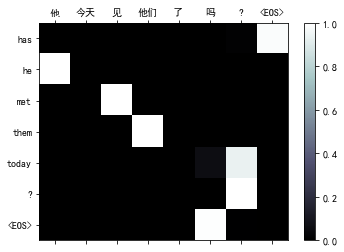

39m 56s (- 1775m 32s) (1100 2%) 0.0371
43m 31s (- 1769m 46s) (1200 2%) 0.0336
47m 7s (- 1765m 37s) (1300 2%) 0.0319
50m 35s (- 1756m 25s) (1400 2%) 0.0309
54m 4s (- 1748m 14s) (1500 3%) 0.0305
57m 29s (- 1739m 20s) (1600 3%) 0.0287
61m 1s (- 1733m 58s) (1700 3%) 0.0279
64m 27s (- 1726m 7s) (1800 3%) 0.0262
67m 58s (- 1721m 0s) (1900 3%) 0.0424
71m 26s (- 1714m 28s) (2000 4%) 0.0593
> 那 是 我们 的 房子 。
= that s our house .
< that s our house . <EOS>


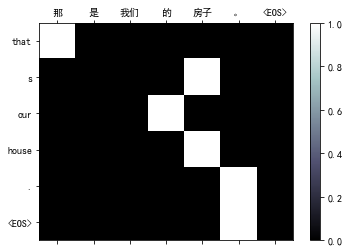

74m 52s (- 1707m 50s) (2100 4%) 0.0314
78m 22s (- 1702m 56s) (2200 4%) 0.0248
81m 49s (- 1697m 2s) (2300 4%) 0.0248
85m 18s (- 1691m 59s) (2400 4%) 0.0255
88m 48s (- 1687m 24s) (2500 5%) 0.0237
92m 19s (- 1683m 8s) (2600 5%) 0.0243
95m 53s (- 1679m 50s) (2700 5%) 0.0228
99m 26s (- 1676m 16s) (2800 5%) 0.0233
102m 56s (- 1672m 2s) (2900 5%) 0.0234
106m 35s (- 1669m 58s) (3000 6%) 0.0216
> 她 为 甚 么 要 说谎 ?
= why would she lie ?
< why would she lie ? <EOS>


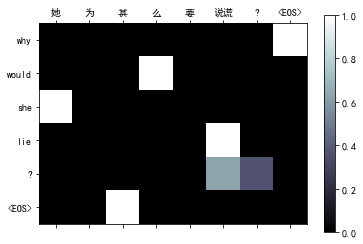

110m 7s (- 1666m 4s) (3100 6%) 0.0225
113m 40s (- 1662m 28s) (3200 6%) 0.0232
117m 10s (- 1658m 13s) (3300 6%) 0.0228
120m 38s (- 1653m 23s) (3400 6%) 0.0281
124m 8s (- 1649m 21s) (3500 7%) 0.0496
127m 43s (- 1646m 10s) (3600 7%) 0.0471
131m 19s (- 1643m 19s) (3700 7%) 0.0283
134m 53s (- 1639m 55s) (3800 7%) 0.0240
138m 28s (- 1636m 51s) (3900 7%) 0.0240
142m 7s (- 1634m 29s) (4000 8%) 0.0216
> 每个 人 都 认识 她 。
= everybody knows her .
< everybody knows her . <EOS>


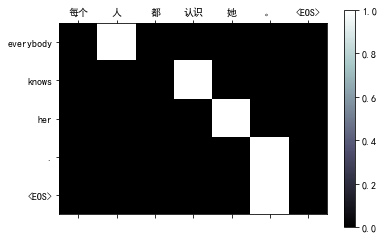

145m 40s (- 1630m 52s) (4100 8%) 0.0226
149m 32s (- 1630m 47s) (4200 8%) 0.0217
153m 17s (- 1629m 7s) (4300 8%) 0.0228
156m 55s (- 1626m 16s) (4400 8%) 0.0222
160m 26s (- 1622m 12s) (4500 9%) 0.0218
164m 7s (- 1619m 49s) (4600 9%) 0.0214
167m 37s (- 1615m 34s) (4700 9%) 0.0209
171m 7s (- 1611m 25s) (4800 9%) 0.0209
174m 34s (- 1606m 47s) (4900 9%) 0.0222
178m 7s (- 1603m 10s) (5000 10%) 0.0210
> 你 怎么 洋 ?
= how about you ?
< how about you ? <EOS>


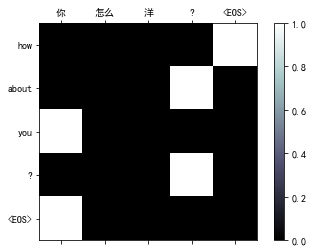

181m 42s (- 1599m 49s) (5100 10%) 0.0225


In [ ]:
# Begin!
ecs = []
dcs = []
eca = 0
dca = 0

while epoch < n_epochs:
    epoch += 1
    
    # Get training data for this cycle
    input_batches, input_lengths, target_batches, target_lengths = random_batch(batch_size)

    # Run the train function
    loss, ec, dc = train(
        input_batches, input_lengths, target_batches, target_lengths,
        encoder, decoder,
        encoder_optimizer, decoder_optimizer, criterion
    )

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss
    eca += ec
    dca += dc


    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)
        
    if epoch % evaluate_every == 0:
        evaluate_randomly()

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0
        
        # TODO: Running average helper
        ecs.append(eca / plot_every)
        dcs.append(dca / plot_every)
        ecs_win = 'encoder grad (%s)' % hostname
        dcs_win = 'decoder grad (%s)' % hostname
        vis.line(np.array(ecs), win=ecs_win, opts={'title': ecs_win})
        vis.line(np.array(dcs), win=dcs_win, opts={'title': dcs_win})
        eca = 0
        dca = 0

## 损失绘图

In [ ]:
def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

In [ ]:
output_words, attentions = evaluate("你 爱 音乐 吗 ？")
plt.matshow(attentions.numpy())
show_plot_visdom()

In [ ]:
evaluate_and_show_attention("你 爱 音乐 吗 ？")